In [81]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_
from tqdm.notebook import tqdm as tqdm_step

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

from graphviz import Digraph

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [2]:
DIR_TRAIN = "./dataset/train/"
DIR_TEST = "./dataset/test/"

PATH_TRAIN = "./dataset/train.csv"
PATH_TEST = "./dataset/test.csv"

In [3]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        image = cv2.imread(DIR_TRAIN + f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [4]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [5]:
!unzip ./1.zip -d ./newpic/

Archive:  ./1.zip
replace ./newpic/0-Кран/932_original.webp? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [6]:
!unzip -u ./2.zip -d ./newpic/

Archive:  ./2.zip


In [7]:
from os import listdir
from os.path import isfile, join

In [8]:
arr_file = []
for dir_ in [e[0] for e in os.walk('./newpic')]:
    onlyfiles = [f for f in listdir(dir_) if isfile(join(dir_, f))]
    class_ = dir_.split('/')[-1].split('-')[0]
    for file_dir in onlyfiles:
        ext = file_dir.split('.')[-1]
        arr_file.append({'ID_img':os.path.join(dir_, file_dir), 'class':float(class_), 'ext':ext})

In [9]:
new_data = pd.DataFrame(data=arr_file)

In [10]:
len(new_data)

2416

In [11]:
new_data = new_data.loc[new_data['ext'].isin(['html', 'gif']) != True]

In [12]:
new_data[['ID_img', 'class']]

,ID_img,class
0,./newpic/0-Кран/g16272_9398367.jpg,0.0
1,./newpic/0-Кран/240113_G4ct0 (1).webp,0.0
2,./newpic/0-Кран/634_original.webp,0.0
3,./newpic/0-Кран/avtokran-terex-demag-ac-500-2-...,0.0
4,./newpic/0-Кран/KS4561A_2.jpg,0.0
...,...,...
2411,./newpic/6-Каток/670_original.jpg,6.0
2412,./newpic/6-Каток/30993713.jpg,6.0
2413,./newpic/6-Каток/i (9).webp,6.0
2414,./newpic/6-Каток/465_original.webp,6.0


Загруим датасет как архив и откроем его 

In [101]:
!unzip МФТИ.zip -d /content/МФТИ/

unzip:  cannot find or open МФТИ.zip, МФТИ.zip.zip or МФТИ.zip.ZIP.


In [13]:
# читаем датасет
data_df = pd.read_csv(PATH_TRAIN)

In [14]:
data_df['ID_img'] = [os.path.join(DIR_TRAIN,e) for e in data_df['ID_img'].to_numpy()]

In [15]:
data_df = pd.concat([data_df, new_data[['ID_img', 'class']]])

In [16]:
data_df.head(3)

,ID_img,class
0,./dataset/train/2138.jpg,4.0
1,./dataset/train/2139.jpg,6.0
2,./dataset/train/2140.jpg,3.0


In [17]:
for d in data_df['ID_img'].to_numpy():
    if not os.path.isfile(d):
        print(d, os.path.isfile(d))

In [18]:
from os import listdir

print("Обучающей выборки " ,len(listdir(DIR_TRAIN)))
print("Тестовой выборки " ,len(listdir(DIR_TEST)))

Обучающей выборки  4990
Тестовой выборки  2138


<AxesSubplot:xlabel='class', ylabel='count'>

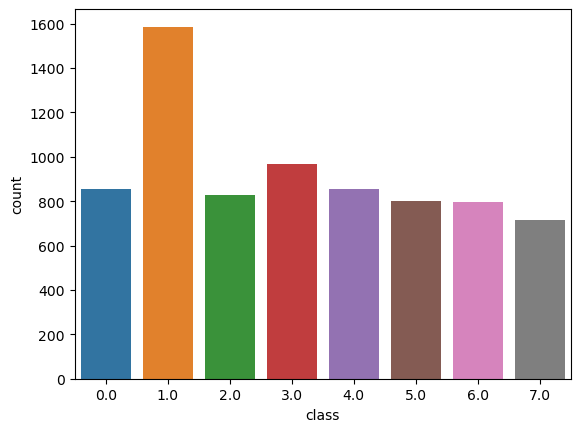

In [19]:
import seaborn as sns
import warnings

warnings.simplefilter('ignore')
sns.countplot(x = "class" , data  = data_df)

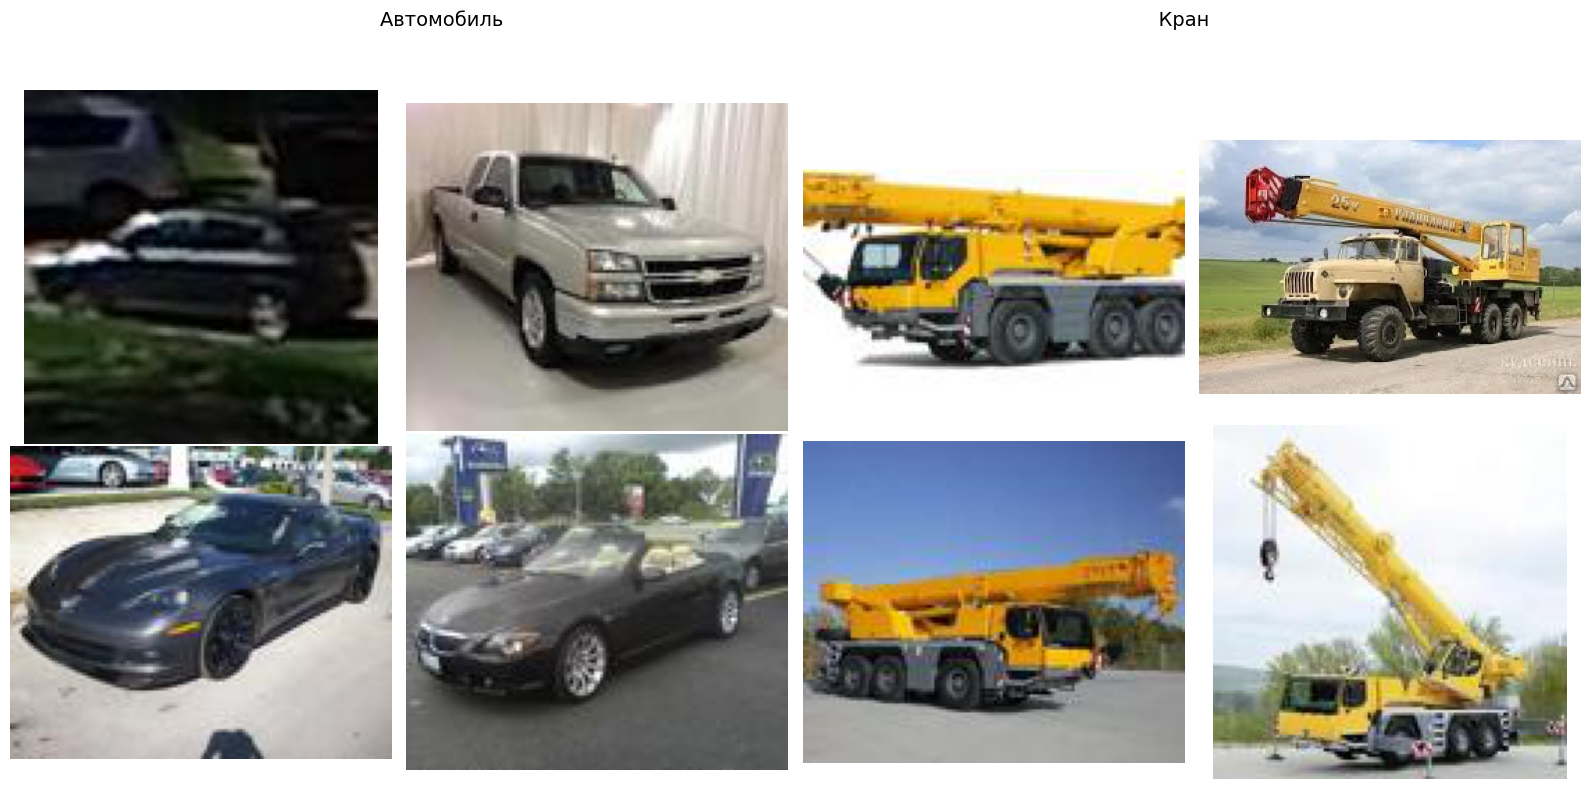

In [20]:
# посмотрим на картинки. Не забудем указать корретный путь до папки

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Автомобиль {" "*105} Кран', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['class'] == 1 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(name))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['class'] == 0 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(name))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [21]:
train_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [ ]:
data_df = data_df.loc[data_df['ID_img'].isin(['./newpic/7-Бульдозер/main_bg.jpg',])!=True]

In [22]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=43)

In [23]:
train_df.shape, valid_df.shape

((5920, 2), (1480, 2))

In [24]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [25]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=32,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

## Вспомогательные функции

In [26]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        val_acc = valid(res_model,criterion,optimizer,val_loader)
        val_score.at[i] = val_acc
    
    return train_score,val_score

In [27]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    dd = list(map(lambda x: x.cpu().detach().numpy(), train_history))
    plt.plot(dd, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [28]:
import os
import json

In [29]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, device, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    pbar_epoch = tqdm_step(range(NUM_EPOCH), desc="Epoch")
    
    for epoch in pbar_epoch:
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.
        pbar_train = tqdm_step(train_dataloader, desc="Training")

        for imgs, labels, _ in pbar_train:
            try:
                optimizer.zero_grad()

                imgs = imgs.to(device)
                labels = labels.to(device)

                y_pred = model(imgs)

                loss = criterion(y_pred, labels)
                loss.backward()

                l = loss.item()
                train_loss += l
                train_size += y_pred.size(0)
                train_loss_log.append(loss.data / y_pred.size(0))

                pred_acc = (y_pred.argmax(-1) == labels.argmax(-1)).sum()

                train_pred += pred_acc

                optimizer.step()
                pbar_train.postfix = f"loss = {l},  acc = {pred_acc/y_pred.size(0)}"
            except Exception as ex:
                pbar_train.postfix = f"loss = {l},  acc = {pred_acc/y_pred.size(0)}"
                ## логирование
                

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            pbar_testing = tqdm_step(test_dataloader, desc="Testing")
            for imgs, labels, _ in pbar_testing:
                try:
                
                    imgs = imgs.to(device)
                    labels = labels.to(device)

                    pred = model(imgs)
                    loss = criterion(pred, labels)
                    l = loss.item()
                    val_loss += l
                    val_size += pred.size(0)
                    pred_acc = (pred.argmax(-1) == labels.argmax(-1)).sum()
                    val_pred += pred_acc
                    pbar_testing.postfix = f"loss = {l},  acc = {pred_acc / pred.size(0)}"
                except Exception as ex:
                    pbar_testing.postfix = f"loss = {l},  acc = {pred_acc / pred.size(0)}"
                    ## логирование
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        print(f'Epoch {NUM_EPOCH}/{epoch+1}')
        print('-----')
        print('Train loss:' + str((train_loss / train_size)*100))
        print('Val loss:' + str((val_loss / val_size)*100))
        print('Train acc:' + str((train_pred / train_size)*100))
        val_acc = (val_pred / val_size)*100
        print('Val acc:'+ str(val_acc))
        
        
        if not os.path.exists("./last.state"):
            with open("./last.state", "w") as f:
                f.write(json.dumps({"val_acc":val_acc.item()}))
        else:
            with open("./last.state", "r") as f:
                val = f.read()
                state = json.loads(val)
            if val_acc > state["val_acc"]:
                with open("./last.state", "w") as f:
                    f.write(json.dumps({"val_acc":val_acc.item()}))
                if os.path.exists("./best_model.mdl"):
                    os.rename('./best_model.mdl', f'./model_{str(state["val_acc"])}.mdl')
                torch.save(model.state_dict(), './best_model.mdl')
                print('Сохранено!')
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

## Модель

Если надо почистить память

In [30]:
import gc

gc.collect()

10

In [31]:
torch.cuda.empty_cache()

In [32]:
import torch.nn.functional as F
import random
from PIL import Image as PImage

In [33]:
params = {
    "path":["./DBeaver_dataset.json", "./MonitorOff_dataset.json", "./PyCharm_dataset.json", "./SSMS_dataset.json", "./VisualStudio_dataset.json", "./Windows_enter_dataset.json"],
    "path_img":"./Dataset/",
    "lr": 0.0001,
    "batch_size": 32,
    "num_workers": 4,
    "epochs": 4,
    "size": 128,
    "device": torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
    "path_model":"./best_model.mdl",
}

In [34]:
train_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [35]:
train_transform = transforms.Compose([
    #trf.ToPILImage(),
    #trf.Resize((512, 512)),
    transforms.Resize((int(params['size'] * 1.3), int(params['size'] * 1.3))),
    #trf.Resize((int(params['size']), int(params['size']))),
    transforms.RandomCrop((params['size'], params['size'])),
    transforms.RandomRotation(5.0),
    transforms.RandomAffine(degrees=(-2,2), translate=(0, 0.15), scale=(0.90, 1.0)),
    #trf.RandomApply(transforms=[trf.ElasticTransform(alpha=50.0)], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.02, hue=0.02), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])
valid_transform = transforms.Compose([
    transforms.Resize((params['size'], params['size'])),
    #transforms.RandomResizedCrop(params['size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [36]:
all_class = set()
for e in np.unique(train_df['class'].to_numpy()):
    all_class.add(int(e))
for e in np.unique(valid_df['class'].to_numpy()):
    all_class.add(int(e))
all_class

{0, 1, 2, 3, 4, 5, 6, 7}

In [38]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        #print(self.data_df.iloc[idx]['ID_img'])
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(np.array([1.0 if idx == label else 0.0 for idx, e in enumerate(range(len(all_class)))])), image_name
    
    def __len__(self):
        return len(self.data_df)

In [48]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [53]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=params['batch_size'],
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=params['num_workers'])

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=params['batch_size'],
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=params['num_workers'])

In [54]:
class CNN(nn.Module):
    def __init__(self, **kwargs):
        super(CNN, self).__init__()
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(in_channels=kwargs["input_shape"], out_channels=64, kernel_size=(4, 4)),
        )
        
        self.maxpooling1 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.BatchNorm2d(64),
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 4)),
        )
        
        self.maxpooling2 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
        )
        
        self.convlayer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 4)),
        )
        
        self.maxpooling3 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.25),
            nn.BatchNorm2d(64),
        )
        
        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=53824, out_features=len(all_class), bias=True),
        )

    def forward(self, x):
        x = nn.functional.relu(self.convlayer1(x))
        x = self.maxpooling1(x)
        x = nn.functional.relu(self.convlayer2(x))
        x = self.maxpooling2(x)
        x = nn.functional.relu(self.convlayer3(x))
        x = self.maxpooling3(x)
        x = nn.functional.softmax(self.flatten(x), -1)
        
        return x

In [56]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=False, strides=1, padding=0, activation='relu'):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   groups=in_channels, bias=bias, padding=padding, stride=strides)
        self.pointwise = nn.Conv2d(in_channels, out_channels,
                                   kernel_size=1, bias=bias, stride=strides)
        self.activation = activation
    def forward(self, x):
        out1 = torch.relu(self.depthwise(x))
        out1 = torch.relu(self.pointwise(out1))
        
        out2 = torch.nn.functional.elu(self.depthwise(x))
        out2 = torch.nn.functional.elu(self.pointwise(out2))
        
        out = torch.cat((out1, out2), dim=-1)

        return out

In [59]:
class CNN(nn.Module):
    def __init__(self, **kwargs):
        super(CNN, self).__init__()
        self.convlayer0_1 = nn.Sequential(
            nn.Conv2d(in_channels=kwargs["input_shape"], out_channels=16, kernel_size=(4, 4), padding=2),
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(4, 4),padding=2),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(24),
        )
        
        self.convlayer0_2 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(5, 5),padding=2),
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(5, 5),padding=2),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(48),
        )
        
        self.convlayer0_3 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(5, 5),padding=1),
            nn.Conv2d(in_channels=64, out_channels=92, kernel_size=(5, 5),padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(92),
        )
        
        self.convlayer1 = nn.Sequential(
            SeparableConv2d(in_channels=92, out_channels=128, kernel_size=(5, 5), strides=1,padding=1),
            nn.BatchNorm2d(128), #nn.ReLU(),
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), strides=1,padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128), #nn.ReLU(),
        )
        self.convlayer2 = nn.Sequential(
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), strides=1,padding=1), #nn.ReLU(),
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), strides=1,padding=1), #nn.ReLU(),
        )
        self.convlayer3 = nn.Sequential(
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), strides=1,padding=1),
            nn.BatchNorm2d(128), #nn.ReLU(),
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(3,3), strides=1,padding=1),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128), #nn.ReLU(),
        )
        
        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=38912, out_features=1024),
            nn.Linear(in_features=1024, out_features=512),
            nn.Linear(in_features=512, out_features=256),
            nn.Linear(in_features=256, out_features=128),
            nn.Linear(in_features=128, out_features=64),
            nn.Dropout(0.2),
            nn.BatchNorm1d(64), #nn.ReLU(),
        )
        self.pred = nn.Sequential(
            nn.Linear(in_features=64, out_features=len(all_class), bias=True),
        )

    def forward(self, x):
        x = nn.functional.relu(self.convlayer0_1(x))
        x = nn.functional.relu(self.convlayer0_2(x))
        x = nn.functional.relu(self.convlayer0_3(x))
        x = nn.functional.relu(self.convlayer1(x))
        x = nn.functional.relu(self.convlayer2(x))
        x = nn.functional.relu(self.convlayer3(x))
        x = nn.functional.relu(self.flatten(x))
        x = nn.functional.log_softmax(self.pred(x), -1)
        
        return x

In [61]:
class CNN(nn.Module):
    def __init__(self, **kwargs):
        super(CNN, self).__init__()
        self.convlayer0_1 = nn.Sequential(
            nn.Conv2d(in_channels=kwargs["input_shape"], out_channels=32, kernel_size=(1, 1), padding=2),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(4, 4), padding=2),
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(4, 4),padding=2),
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(1, 1)),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(24),
        )
        
        self.convlayer0_2 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(5, 5),padding=2),
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(5, 5),padding=2),
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(1, 1)),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(48),
        )
        
        self.convlayer0_3 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(5, 5),padding=1),
            nn.Conv2d(in_channels=64, out_channels=92, kernel_size=(5, 5),padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(92),
        )
        
        self.convlayer1 = nn.Sequential(
            SeparableConv2d(in_channels=92, out_channels=128, kernel_size=(5, 5), strides=1,padding=1),
            nn.BatchNorm2d(128), #nn.ReLU(),
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), strides=1,padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128), #nn.ReLU(),
        )
        self.convlayer2 = nn.Sequential(
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), strides=1,padding=1), #nn.ReLU(),
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), strides=1,padding=1), #nn.ReLU(),
        )
        self.convlayer3 = nn.Sequential(
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), strides=1,padding=1),
            nn.BatchNorm2d(128), #nn.ReLU(),
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(1, 1), strides=1),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128), #nn.ReLU(),
        )
        
        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=39040, out_features=1024),
            nn.Linear(in_features=1024, out_features=512),
            nn.Linear(in_features=512, out_features=256),
            nn.Linear(in_features=256, out_features=128),
            nn.Linear(in_features=128, out_features=64),
            nn.Dropout(0.2),
            nn.BatchNorm1d(64), #nn.ReLU(),
        )
        self.pred = nn.Sequential(
            nn.Linear(in_features=64, out_features=len(all_class), bias=True),
        )
        
        self.convlayer_0_alter = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(9, 9)),
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(9, 9)),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(48),
        )
        self.convlayer_1_alter = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(6, 6)),
            nn.Conv2d(in_channels=64, out_channels=76, kernel_size=(6, 6)),
            nn.Conv2d(in_channels=76, out_channels=76, kernel_size=(1, 1)),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(76),
        )
        self.convlayer_2_alter = nn.Sequential(
            nn.Conv2d(in_channels=76, out_channels=88, kernel_size=(5, 5)),
            nn.Conv2d(in_channels=88, out_channels=88, kernel_size=(1, 1)),
            nn.Dropout(0.2),
            nn.BatchNorm2d(88),
        )
        self.convlayer_3_alter = nn.Sequential(
            nn.Conv2d(in_channels=88, out_channels=128, kernel_size=(3, 3)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1, 1)),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
        )

    def forward(self, x):
        x = nn.functional.relu(self.convlayer0_1(x))
        
        x_alt = nn.functional.relu(self.convlayer_0_alter(x))
        x_alt = nn.functional.relu(self.convlayer_1_alter(x_alt))
        x_alt = nn.functional.relu(self.convlayer_2_alter(x_alt))
        x_alt = nn.functional.relu(self.convlayer_3_alter(x_alt))
        
        x = nn.functional.relu(self.convlayer0_2(x))
        x = nn.functional.relu(self.convlayer0_3(x))
        x = nn.functional.relu(self.convlayer1(x))
        x = nn.functional.relu(self.convlayer2(x))
        x = nn.functional.relu(self.convlayer3(x))
        
        x = torch.cat((x, x_alt), dim=-1)
        
        x = nn.functional.relu(self.flatten(x))
        x = nn.functional.log_softmax(self.pred(x), -1)
        
        return x

In [62]:
device = torch.device(params['device'])
model = CNN(input_shape=3).to(device)
criterion = nn.MSELoss()

In [63]:
criterion = nn.CrossEntropyLoss()

In [64]:
def calculate_accuracy_(target, output):
    return float(torch.sum(torch.eq(torch.argmax(target, dim=1),torch.argmax(output, dim=1))).numpy())/ len(target)

In [65]:
optimizer = optim.Adam(model.parameters(), lr=params['lr'])#1e-3)

In [97]:
params['path_model']

'./best_model.mdl'

In [98]:
try:
    print(model.load_state_dict(torch.load(params['path_model'])))
except:
    print("Модель не загрузилась")

Модель не загрузилась


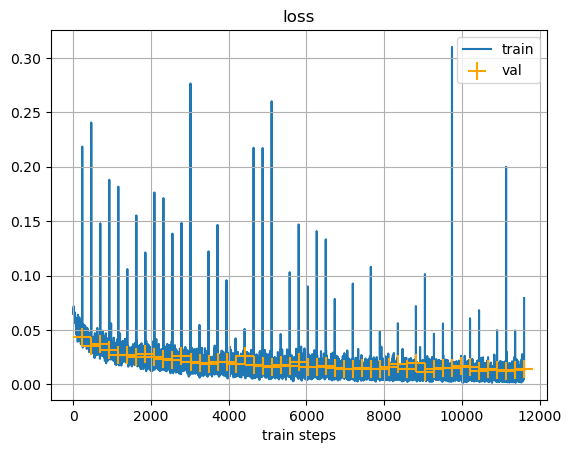

Epoch 50/50
-----
Train loss:0.9430915552674892
Val loss:1.4184313533197717
Train acc:tensor(90.5257, device='cuda:1')
Val acc:tensor(87.3246, device='cuda:1')
CPU times: user 48min 33s, sys: 59.7 s, total: 49min 33s
Wall time: 49min 2s


In [66]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

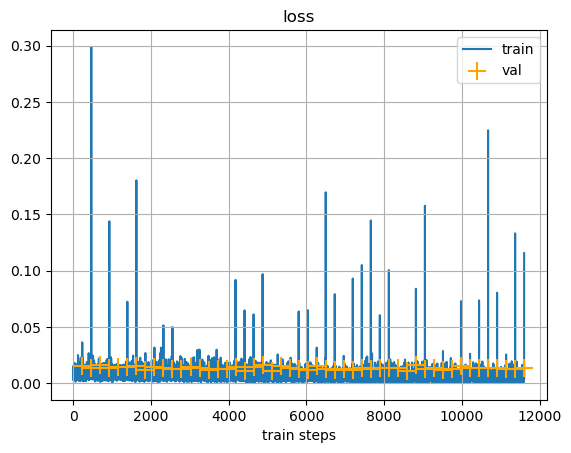

Epoch 50/50
-----
Train loss:0.5195671760225449
Val loss:1.3593636971990226
Train acc:tensor(94.9588, device='cuda:1')
Val acc:tensor(89.0552, device='cuda:1')
CPU times: user 48min 52s, sys: 1min, total: 49min 53s
Wall time: 49min 20s


In [67]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

In [68]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.1)

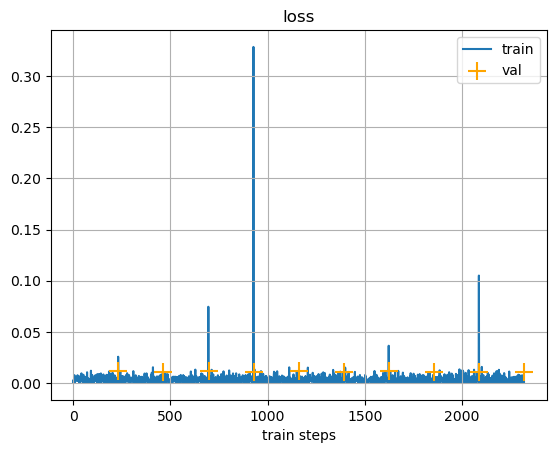

Epoch 10/10
-----
Train loss:0.32137251955669444
Val loss:1.1180808885063065
Train acc:tensor(96.9455, device='cuda:1')
Val acc:tensor(92.0486, device='cuda:1')
CPU times: user 9min 47s, sys: 12.1 s, total: 9min 59s
Wall time: 9min 52s


In [70]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 10)

In [90]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.05)

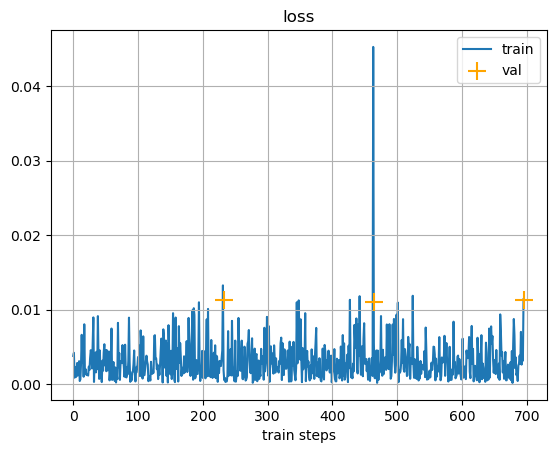

Epoch 10/3
-----
Train loss:0.30262389681420926
Val loss:1.1239851779608985
Train acc:tensor(96.9455, device='cuda:1')
Val acc:tensor(91.7212, device='cuda:1')


Training:   0%|          | 0/232 [00:00<?, ?it/s]

In [ ]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 10)

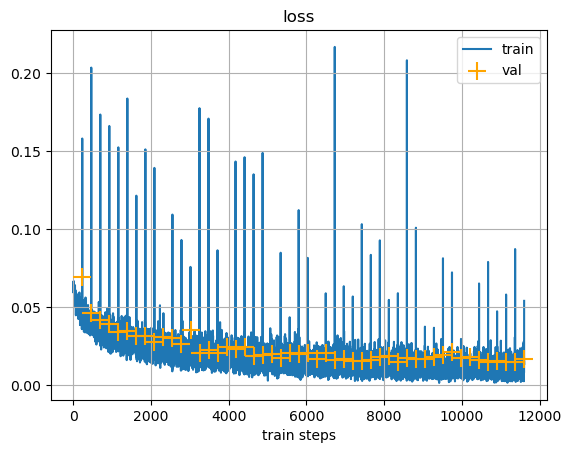

Epoch 50/50
-----
Train loss:0.9694120741042438
Val loss:1.6489425047182822
Train acc:tensor(90.3906, device='cuda:1')
Val acc:tensor(84.8924, device='cuda:1')
CPU times: user 45min 38s, sys: 57.9 s, total: 46min 36s
Wall time: 46min 3s


In [114]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

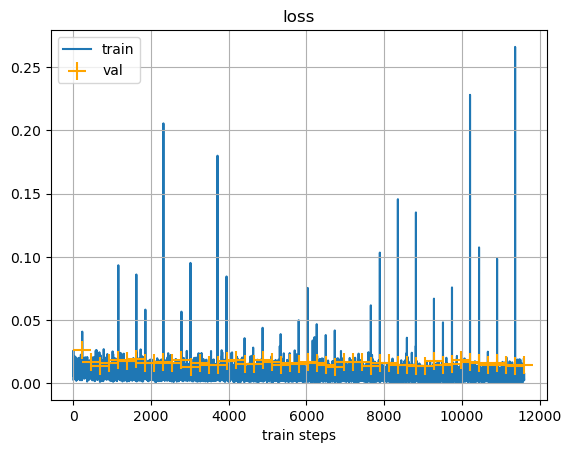

Epoch 50/50
-----
Train loss:0.6172822782817363
Val loss:1.4365203780515465
Train acc:tensor(93.7965, device='cuda:1')
Val acc:tensor(88.0730, device='cuda:1')
CPU times: user 45min 46s, sys: 1min, total: 46min 46s
Wall time: 46min 16s


In [115]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

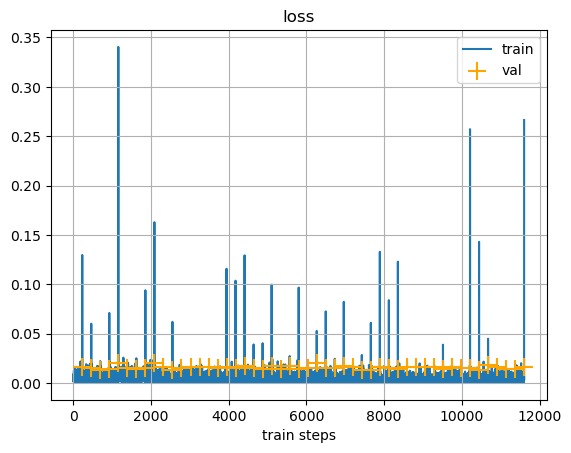

Epoch 50/50
-----
Train loss:0.4442814529253185
Val loss:1.6777554276624356
Train acc:tensor(95.7832, device='cuda:1')
Val acc:tensor(87.4181, device='cuda:1')
CPU times: user 45min 51s, sys: 1min 1s, total: 46min 52s
Wall time: 46min 23s


In [116]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

In [125]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.1)

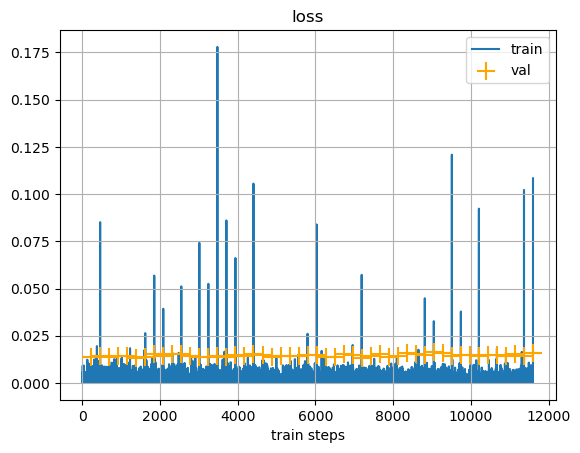

Epoch 50/50
-----
Train loss:0.22193453433750812
Val loss:1.5727111945223087
Train acc:tensor(97.7565, device='cuda:1')
Val acc:tensor(89.2891, device='cuda:1')
CPU times: user 45min 54s, sys: 1min, total: 46min 55s
Wall time: 46min 25s


In [126]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

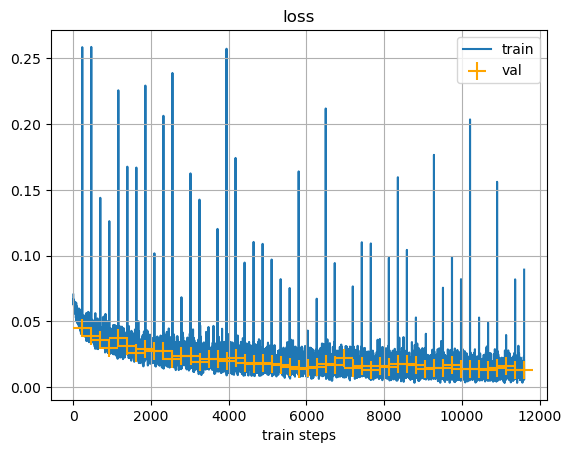

Epoch 50/50
-----
Train loss:1.2818979079539727
Val loss:1.306660755050699
Train acc:tensor(87.2010, device='cuda:1')
Val acc:tensor(88.1197, device='cuda:1')
CPU times: user 43min 11s, sys: 1min, total: 44min 11s
Wall time: 43min 47s


In [122]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

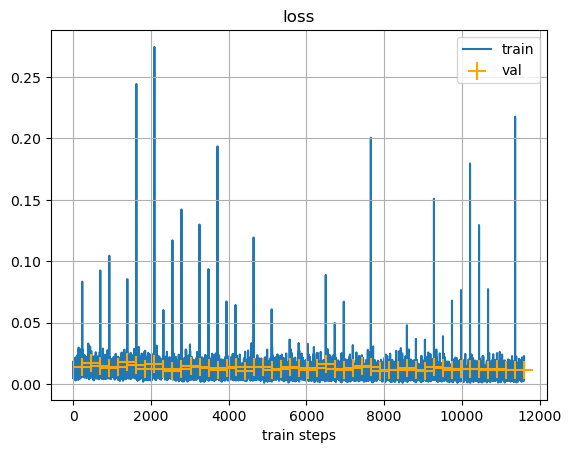

Epoch 50/50
-----
Train loss:0.8998562631992727
Val loss:1.1608373535742311
Train acc:tensor(90.6609, device='cuda:1')
Val acc:tensor(90.9729, device='cuda:1')
CPU times: user 43min 24s, sys: 1min 1s, total: 44min 26s
Wall time: 44min 1s


In [123]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

In [124]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.1)

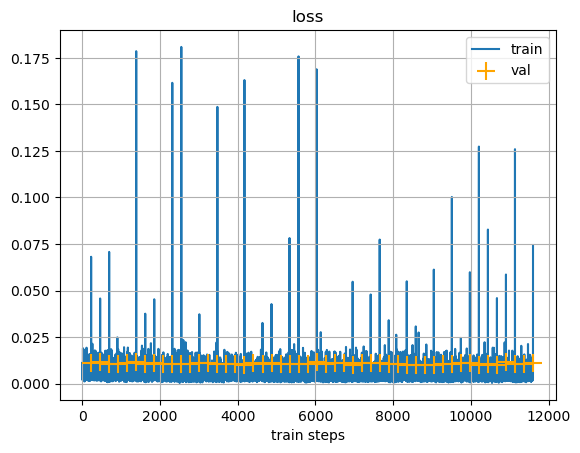

Epoch 50/50
-----
Train loss:0.5702270085187909
Val loss:1.0860877993617728
Train acc:tensor(94.1614, device='cuda:1')
Val acc:tensor(91.9551, device='cuda:1')
CPU times: user 43min 10s, sys: 1min 1s, total: 44min 11s
Wall time: 43min 45s


In [125]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

In [126]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.05)

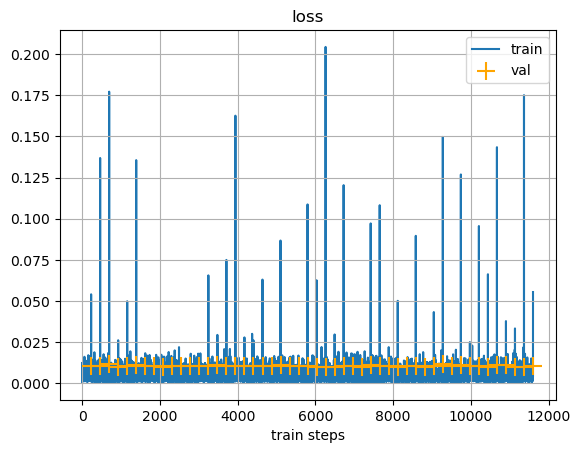

Epoch 50/50
-----
Train loss:0.525270631733658
Val loss:1.074917957676915
Train acc:tensor(94.7561, device='cuda:1')
Val acc:tensor(91.6277, device='cuda:1')
CPU times: user 43min 13s, sys: 1min, total: 44min 13s
Wall time: 43min 45s


In [127]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

In [128]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.01)

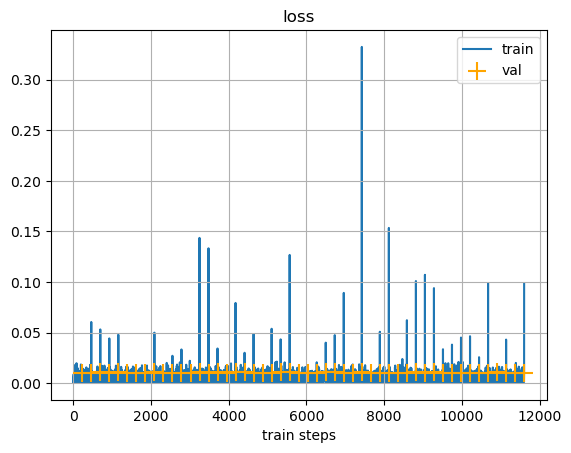

Epoch 50/50
-----
Train loss:0.5015142955819235
Val loss:1.0368365141330447
Train acc:tensor(94.9453, device='cuda:1')
Val acc:tensor(92.3293, device='cuda:1')
CPU times: user 43min 12s, sys: 1min 2s, total: 44min 15s
Wall time: 43min 49s


In [129]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

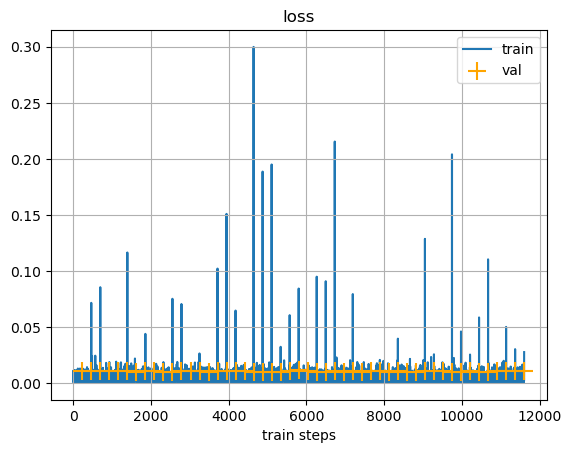

Epoch 50/50
-----
Train loss:0.46659292327125224
Val loss:1.0581495708840265
Train acc:tensor(95.1345, device='cuda:1')
Val acc:tensor(92.0954, device='cuda:1')
CPU times: user 43min 18s, sys: 1min 1s, total: 44min 20s
Wall time: 43min 53s


In [130]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

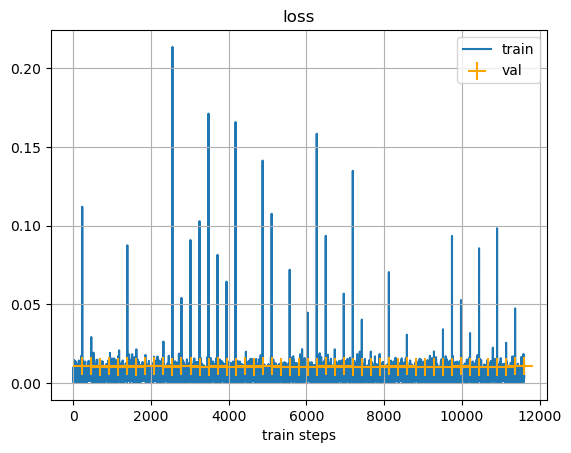

Epoch 50/50
-----
Train loss:0.4623252734047242
Val loss:1.0678982612146595
Train acc:tensor(95.3372, device='cuda:1')
Val acc:tensor(91.8615, device='cuda:1')
CPU times: user 43min 11s, sys: 1min 1s, total: 44min 12s
Wall time: 43min 46s


In [131]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

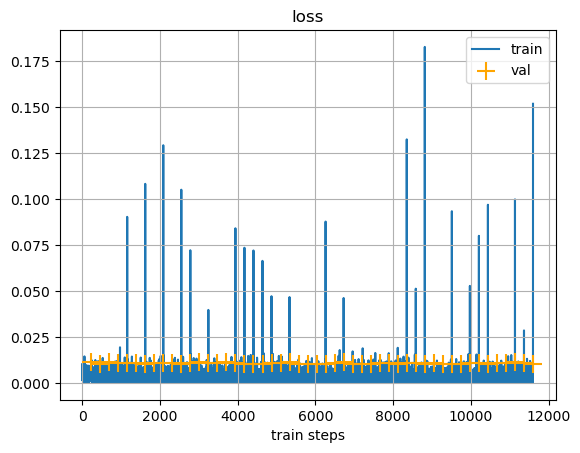

Epoch 50/50
-----
Train loss:0.33089973170471754
Val loss:1.0601758854171102
Train acc:tensor(96.9455, device='cuda:1')
Val acc:tensor(91.8615, device='cuda:1')
CPU times: user 43min 3s, sys: 1min 2s, total: 44min 6s
Wall time: 43min 41s


In [149]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

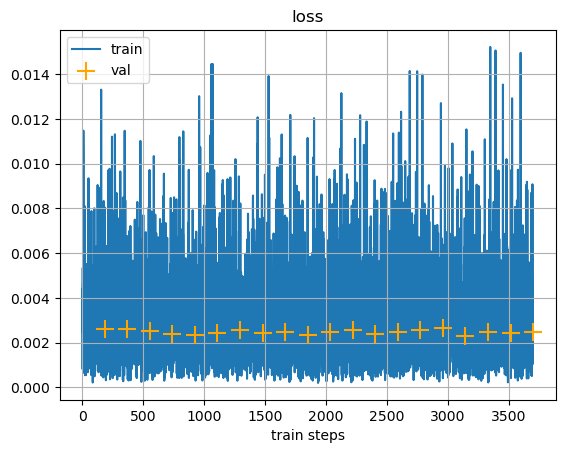

Epoch 20/20
-----
Train loss:0.3308609320648948
Val loss:0.2487151553469089
Train acc:tensor(96.6548, device='cuda:1')
Val acc:tensor(97.4324, device='cuda:1')
CPU times: user 13min 34s, sys: 20.7 s, total: 13min 54s
Wall time: 14min 56s


In [173]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 20)

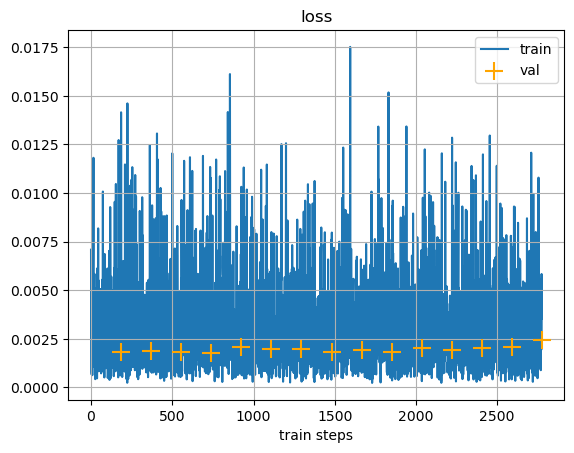

Epoch 15/15
-----
Train loss:0.2974160292819979
Val loss:0.24349644684005528
Train acc:tensor(97.3649, device='cuda:1')
Val acc:tensor(97.9040, device='cuda:1')


NameError: name 'valid' is not defined

In [183]:
%%time
crossvalid(model,criterion,optimizer,data_df.loc[data_df['ID_img'].isin(['./newpic/7-Бульдозер/main_bg.jpg',])!=True],k_fold=5)

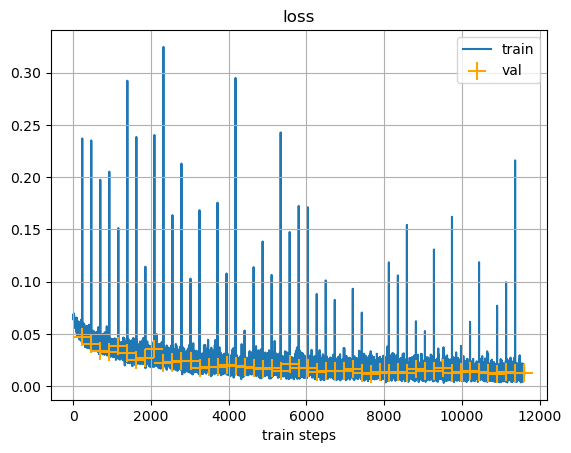

Epoch 50/50
-----
Train loss:1.188723983595897
Val loss:1.2425194950781795
Train acc:tensor(87.5253, device='cuda:1')
Val acc:tensor(89.6632, device='cuda:1')
CPU times: user 1h 24min 38s, sys: 1min 3s, total: 1h 25min 42s
Wall time: 1h 24min 59s


In [440]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

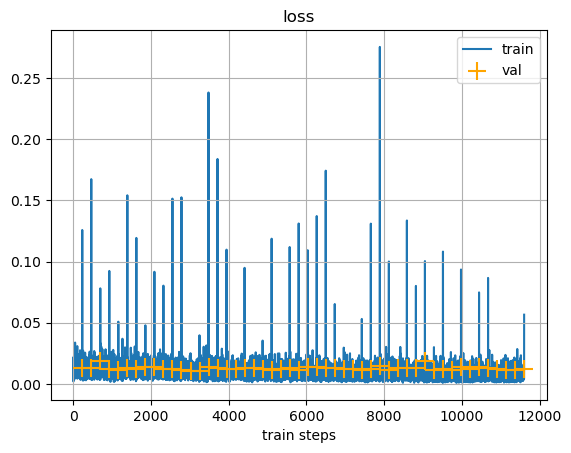

Epoch 50/50
-----
Train loss:0.8184452909996611
Val loss:1.2597797566957252
Train acc:tensor(91.4853, device='cuda:1')
Val acc:tensor(90.0374, device='cuda:1')
CPU times: user 1h 24min 59s, sys: 1min 4s, total: 1h 26min 4s
Wall time: 1h 25min 24s


In [441]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

In [442]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.1)

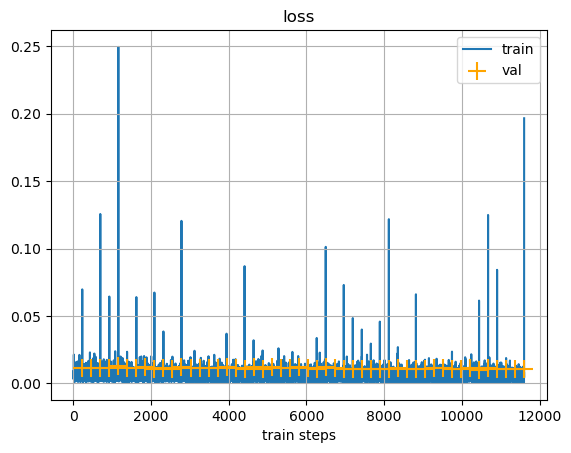

Epoch 50/50
-----
Train loss:0.4804192969795196
Val loss:1.0395199897010825
Train acc:tensor(95.3507, device='cuda:1')
Val acc:tensor(92.1422, device='cuda:1')
CPU times: user 1h 23min 18s, sys: 1min 3s, total: 1h 24min 21s
Wall time: 1h 23min 45s


In [443]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

In [54]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.01)

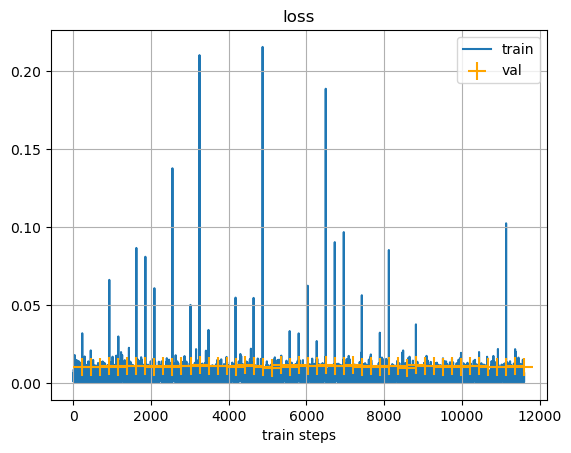

Epoch 50/50
-----
Train loss:0.45234869530303873
Val loss:1.0754798474983582
Train acc:tensor(95.3778, device='cuda:1')
Val acc:tensor(91.6745, device='cuda:1')
CPU times: user 40min 43s, sys: 57.3 s, total: 41min 41s
Wall time: 41min 15s


In [56]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

In [135]:
try:
    print(model.load_state_dict(torch.load('./best_model___.mdl')))
except:
    print("Модель не загрузилась")

Модель не загрузилась


In [136]:
torch.save(model.state_dict(), './best_model___.mdl')
print('Сохранено!')

Сохранено!


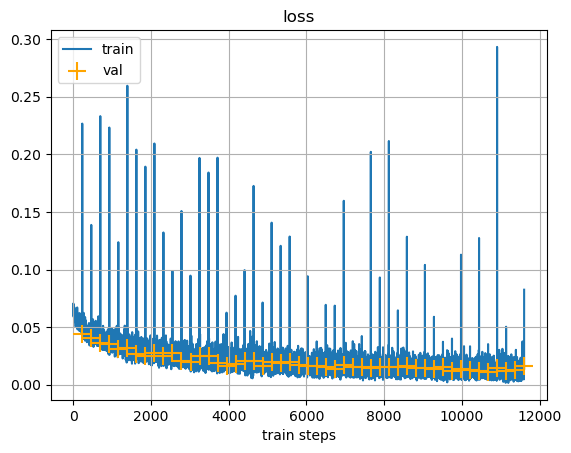

Epoch 50/50
-----
Train loss:1.1884607281809205
Val loss:1.6561560053673892
Train acc:tensor(87.9038, device='cuda:1')
Val acc:tensor(84.8456, device='cuda:1')
CPU times: user 50min 7s, sys: 1min, total: 51min 7s
Wall time: 50min 39s


In [293]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

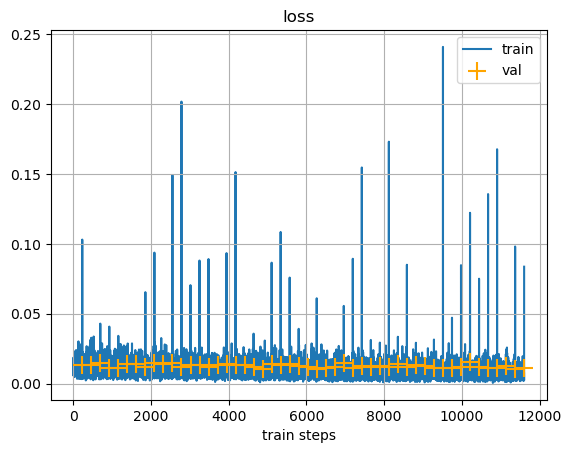

Epoch 50/50
-----
Train loss:0.8064472024862477
Val loss:1.142475021621771
Train acc:tensor(91.9313, device='cuda:1')
Val acc:tensor(91.1132, device='cuda:1')
CPU times: user 51min 13s, sys: 1min 2s, total: 52min 15s
Wall time: 51min 43s


In [294]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

In [359]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.1)

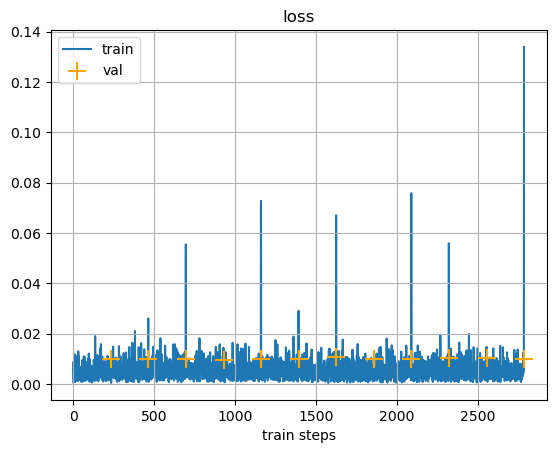

Epoch 12/12
-----
Train loss:0.5135657685613557
Val loss:0.9696074815151818
Train acc:tensor(94.8777, device='cuda:1')
Val acc:tensor(92.7502, device='cuda:1')
CPU times: user 12min 5s, sys: 14.8 s, total: 12min 20s
Wall time: 12min 13s


In [379]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

In [228]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.01)#1e-3)

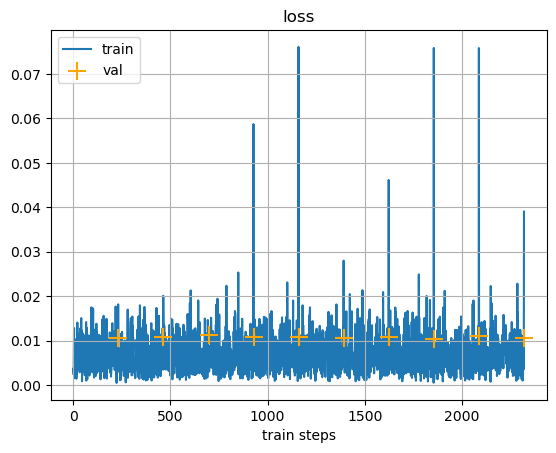

Epoch 10/10
-----
Train loss:0.684837834237942
Val loss:1.061626940124616
Train acc:tensor(93.0261, device='cuda:1')
Val acc:tensor(92.4696, device='cuda:1')
CPU times: user 18min 53s, sys: 12.1 s, total: 19min 5s
Wall time: 18min 57s


In [229]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 10)

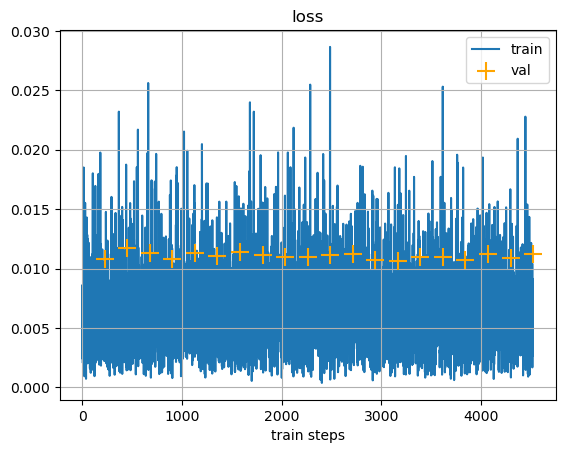

Epoch 20/20
-----
Train loss:0.5930369300238021
Val loss:1.1257260320859492
Train acc:tensor(93.6444, device='cuda:1')
Val acc:tensor(92.0486, device='cuda:1')
CPU times: user 37min 21s, sys: 25.9 s, total: 37min 47s
Wall time: 37min 32s


In [51]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 20)

In [54]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.005)#1e-3)

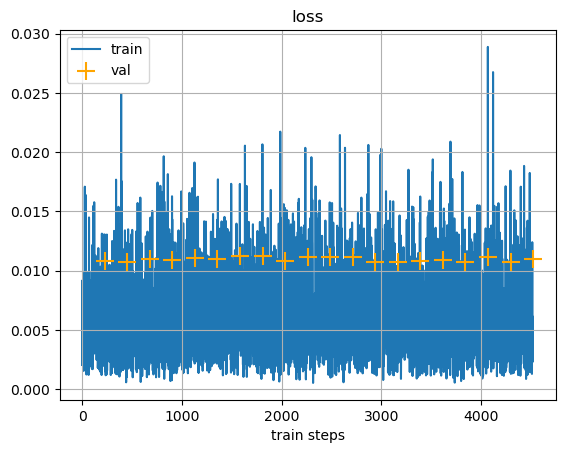

Epoch 20/20
-----
Train loss:0.5996622648246097
Val loss:1.1004153825410539
Train acc:tensor(93.6998, device='cuda:1')
Val acc:tensor(91.7212, device='cuda:1')
CPU times: user 33min 54s, sys: 22.4 s, total: 34min 16s
Wall time: 34min 2s


In [55]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 20)

In [58]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.01)#1e-3)

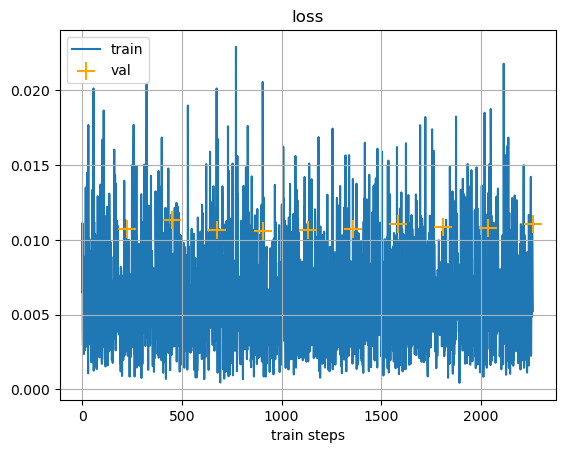

Epoch 10/10
-----
Train loss:0.6281316162424273
Val loss:1.1084223201313113
Train acc:tensor(93.7552, device='cuda:1')
Val acc:tensor(92.3293, device='cuda:1')
CPU times: user 19min 28s, sys: 12.6 s, total: 19min 40s
Wall time: 19min 33s


In [59]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 10)

In [92]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.001)#1e-3)

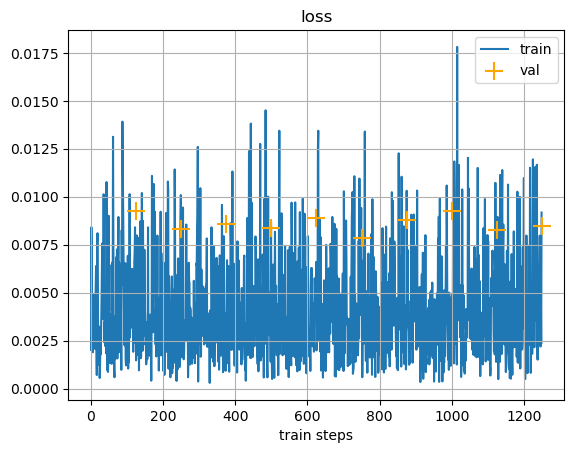

Epoch 10/10
-----
Train loss:0.4470520976099779
Val loss:0.8458118974000386
Train acc:tensor(95.4910, device='cuda:1')
Val acc:tensor(91.8838, device='cuda:1')
CPU times: user 3min 26s, sys: 8.22 s, total: 3min 34s
Wall time: 3min 29s


In [93]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 10)

./dataset/train/6758.jpg


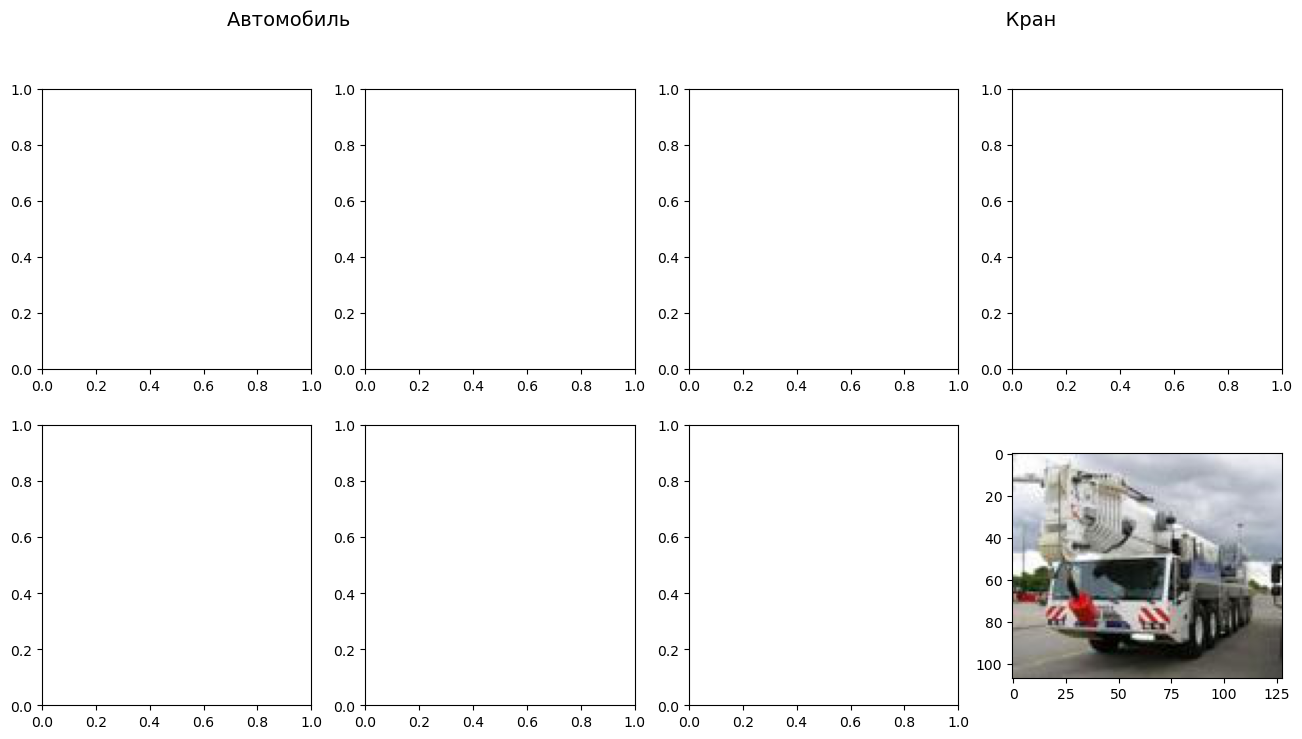

./dataset/train/6085.jpg


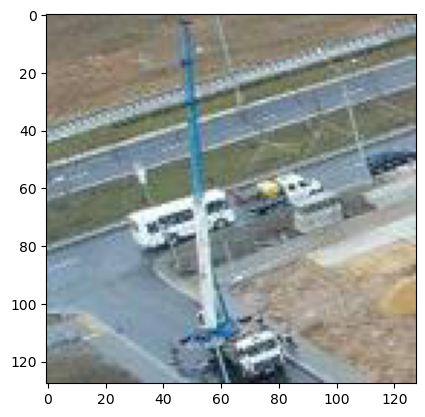

./dataset/train/3360.jpg


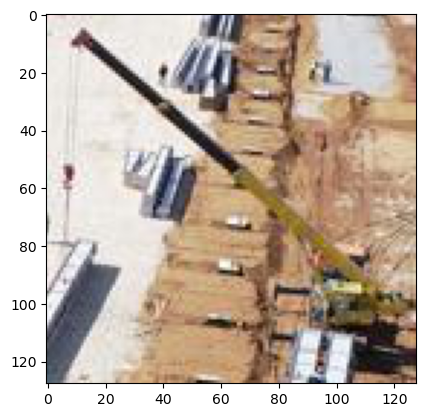

./dataset/train/6274.jpg


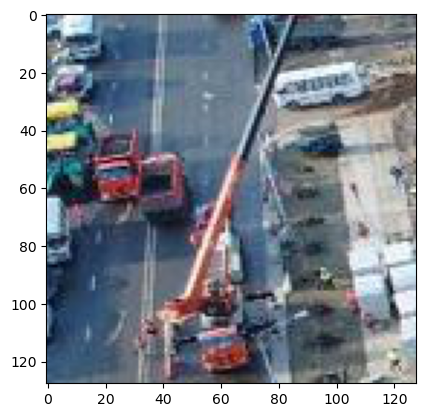

./dataset/train/4840.jpg


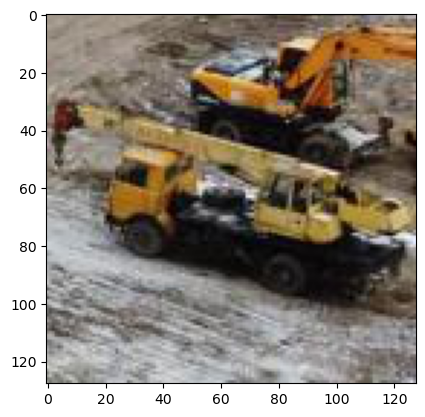

./dataset/train/6186.jpg


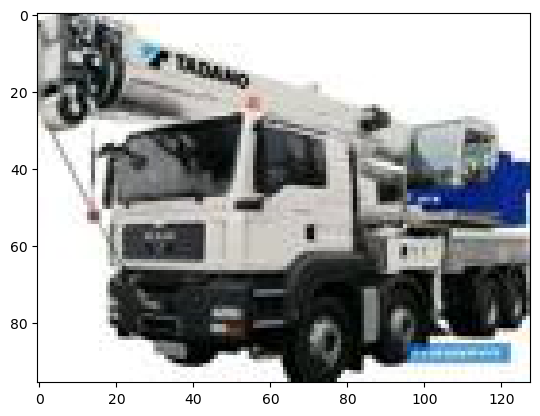

./dataset/train/6582.jpg


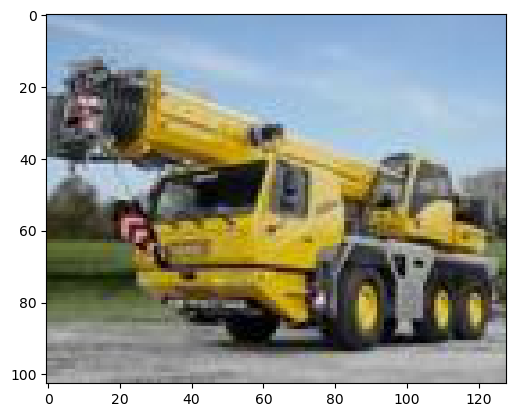

./dataset/train/6191.jpg


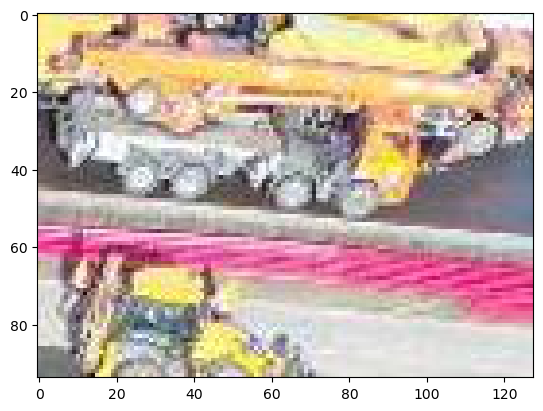

In [169]:
# посмотрим на картинки. Не забудем указать корретный путь до папки

cls = 0

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Автомобиль {" "*105} Кран', fontsize=14)

for i, name in zip(range(4), df_err.loc[(df_err['class']==cls) &  (df_err['name'].str.contains('train'))].sample(4)['name']):
    print(name)
    plt.imshow(plt.imread(name))
    plt.show()
    axs[i // 2, (i % 2)+2].imshow(plt.imread(name))
    axs[i // 2, (i % 2)+2].axis('off')
    #axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), df_err.loc[(df_err['class']==cls) &  (df_err['name'].str.contains('train'))].sample(4)['name']):
    print(name)
    plt.imshow(plt.imread(name))
    plt.show()
    axs[i // 2, (i % 2)+2].imshow(plt.imread(name))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        #print(self.data_df.iloc[idx]['ID_img'])
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(np.array([1.0 if idx == label else 0.0 for idx, e in enumerate(range(len(all_class)))])), image_name
    
    def __len__(self):
        return len(self.data_df)

In [182]:
class ImageDatasetSampler(Dataset):
    def __init__(self, data_df, mask, transform=None):
        self.mask = mask
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[self.mask[idx]]['ID_img'], self.data_df.iloc[self.mask[idx]]['class']
        
        # читаем картинку. read the image
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(np.array([1.0 if idx == label else 0.0 for idx, e in enumerate(range(len(all_class)))])), image_name 
    
    def __len__(self):
        return len(self.mask)

In [180]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))

        train_dataset = ImageDatasetSampler(dataset,train_indices, train_transform)
        valid_dataset = ImageDatasetSampler(dataset,val_indices, valid_transform)
        #train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        #val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], 
                                          shuffle=True, num_workers=params['num_workers'])
        val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=params['batch_size'], 
                                          shuffle=True, num_workers=params['num_workers'])
        
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        #val_acc = valid(res_model,criterion,optimizer,val_loader)
        #val_score.at[i] = val_acc
    
    return train_score#,val_score

In [ ]:
 crossvalid(model,criterion,optimizer,data_df,k_fold=5)

In [419]:
#with open("./last.state", "w") as f:
#    f.write(json.dumps({"val_acc":98.0}))

In [67]:
#val_acc = 96.0671
#with open("./last.state", "r") as f:
#    val = f.read()
#    state = json.loads(val)
#with open("./last.state", "w") as f:
#    f.write(json.dumps({"val_acc":val_acc}))
#if os.path.exists("./best_model.mdl"):
#    os.rename('./best_model.mdl', f'./model_{str(state["val_acc"])}.mdl')
#torch.save(model.state_dict(), './best_model.mdl')
#print('Сохранено!')

In [ ]:
try:
    print(model.load_state_dict(torch.load(params['path_model'])))
except:
    print("Модель не загрузилась")

In [236]:
model.eval()
valid_predicts = []

for imgs, _, _ in tqdm(valid_loader):
    imgs = imgs.to(device)
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 21.63it/s]


In [237]:
valid_df["pred"] = valid_predicts

# Посчитаем recall

In [238]:
from sklearn.metrics import recall_score

In [239]:
val_accuracy = recall_score(valid_df['class'].values, valid_df['pred'].values, average = "macro")
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 0.8982554183295566


## Предскажем для теста

In [127]:
test_df_ = pd.read_csv(PATH_TEST)

In [128]:
test_df = pd.read_csv(PATH_TEST)
test_df = test_df.drop(["class"], axis = 1)

In [129]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['ID_img']
        
        # читаем картинку
        image = cv2.imread(DIR_TEST+ f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [130]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [131]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

#Предсказываем нашей моделью результат

In [132]:
model.eval()
predicts = []

for imgs in tqdm(test_loader):
    imgs = imgs.to(device)
    pred = model(imgs)
    for class_obj in pred:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      predicts.append(index)

100%|███████████████████████████████████████████| 67/67 [00:04<00:00, 16.48it/s]


In [133]:
test_df["class"] = predicts

test_df.head()

,ID_img,class
0,0.jpg,5
1,1.jpg,5
2,2.jpg,1
3,3.jpg,1
4,4.jpg,6


In [134]:
test_df.to_csv("submit.csv", index=False)